# Image To Text Copy Paste

Ever wished to take a screen shot and be able to paste the text inside later? We're gonna do just that!

Let's start with the imports


In [73]:
#hide
%%capture
!pip install opencv-python
!pip install pytesseract
!pip install imutils
!pip install fastai
!pip install imutils
#!wget -r -np TODO

In [1]:
import cv2
import pytesseract
import imutils
from fastai.vision.all import *
import numpy as np
from imutils.object_detection import non_max_suppression

path_east = "frozen_east_text_detection.pb"

class TODO(Exception):
    """Raised when the code needs to be implemented"""
    def __init__(self,  message):
        self.message = message
        super().__init__(self.message)

## **Discussion:** What do we need to do

- UI
- Keyboard
- Model(s)
- Data wrangling

UI / Keyboard tools will have to be done in Python locally. Not possible with WebGUI.

## Baseline 1.0 - Recognizing Text

Let's start with a baseline which is simple to implement yet work.

### Introducing Tesseract
Tesseract is an [_optical character recognition_](https://en.wikipedia.org/wiki/Optical_character_recognition) (OCR) which is Open Source (Apache License), first developed by Hewlett-Packard (HP) during the 80s and started out as proprietary software. In 2005 it became Open Source and Google have been backing it ever since.

In 2006 Tesseract was considered the most accuracte OCR system in the world, which is pretty impressive!

### What is OCR?

A lot of us (Swedes) knows OCR from the OCR-number on our bills.  
![ocr-bill](https://medier.talentum.com/ponIltIpIv-1457371608/media/kg4ryn-OCD-nummer1114.jpg/alternates/FREE_400/OCD-nummer1114.jpg)

In its essence it is about recognizing characters and being able to map them into the correct character.  
![ocr-explanation](https://s3.amazonaws.com/element-ai-website-bucket/_992x587_crop_center-center_82_line/OCR-Handwritten-documents@2x.jpg)


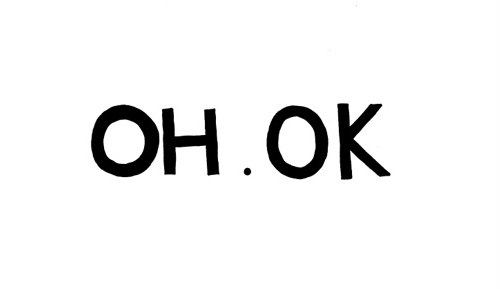

In [2]:
imgs = get_image_files('images')

def create_img(image_path):
    return Image.open(image_path) #raise TODO("Take PILImage and create an image out of imgs[1]")

img = create_img(imgs[1])
img

Now that we've viewed one of the images we can carry on and recognize the characters from this image through Tesseract (our baseline).

**The Tesseract Config**  
`l` for _language_ (default=eng), e.g. `-l 'eng+fra'`

`oem` for _OCR Engine Mode_.
-  0 = Legacy
- 1 = LSTM
- 2 = Tesseract + LSTM
- 3 = What's available

`psm` for _Page Segmentation Mode_
- 0 = Orientation and script detection (OSD) only.
- 1 = Automatic page segmentation with OSD.
- 2 = Automatic page segmentation, but no OSD, or OCR.
- 3 = Fully automatic page segmentation, but no OSD. (Default)
- 4 = Assume a single column of text of variable sizes.
- 5 = Assume a single uniform block of vertically aligned text.
- 6 = Assume a single uniform block of text.
- 7 = Treat the image as a single text line.
- 8 = Treat the image as a single word.
- 9 = Treat the image as a single word in a circle.
- 10 = Treat the image as a single character.




In [3]:
custom_config = r'--oem 3 --psm 3'
pytesseract.image_to_string(img, config=custom_config)# raise TODO("Call pytesseracts image_to_string using the same image (img) you visualized and the custom config")

'OH .OK\n\x0c'

At least the "Oh .Ok" seems to work decently enough... But this is not great. It works, no more, no less!

Baseline 1.0 done!  

## Baseline 2.0 - Find Text to help Tesseract
I hope, and guess, that this was part of the discussion previously. As long as we keep working with _baselines_ we'll do it a simple (and not very custom) way. Let's figure out how we can use `opencv` to recognize text-blocks.

What does this mean?  

- [ ] Parse Image (recognize height, width)
- [ ] Transform Image (normalize)
- [ ] Find the smaller areas where text exists
- [ ] OCR on top of text

All of this is possible through a combination of `opencv` & `tesseract`, which makes perfect sense for a baseline!  
We'll use _Efficient and Accurate Scene Text Detector_ (EAST) which is Open Source, found [here](https://github.com/argman/EAST) and the paper [here](https://arxiv.org/abs/1704.03155v2).  
The model achieves 80.83 F1-score on ICDAR 2015 Incidental Scene Text Detection.

**Performance:** Speed on 720p (resolution of 1280x720) images:   
- Graphic card: GTX 1080 Ti
- Network fprop: ~50 ms
- NMS (C++): ~6ms
- Overall: ~16 fps

Let's start by putting our layers into a list.

In [4]:
layers = layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

def load_net():
    net = cv2.dnn.readNet(path_east) # raise TODO("Make use of cv2 neural net loader (`cv2.dnn.readNet`) and given path previously")
    return net

net = load_net()

In [5]:
def decode_predictions(scores, geometry, min_confidence):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < min_confidence:
				continue

			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

In [6]:
def pil_to_cv2(pil_image):
    return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

def resize_then_make_blob_from_PIL(img, width=320, height=320):
    img = img.resize((width, height))
    cv2_img = pil_to_cv2(img)
    # resize the image and grab the new image dimensions
    #image = cv2.resize(img, (newW, newH))
    (H, W) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2_img, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    return blob

In [7]:
def predict(net, img, layers=layerNames, min_confidence=0.5):
    net.setInput(resize_then_make_blob_from_PIL(img))
    (scores, geometry) = net.forward(layers)
    (rects, confidences) = decode_predictions(scores, geometry, min_confidence)

(rectangles, confidences) = non_max_suppression(np.array(rects), probs=confidences)

return 

NameError: name 'rects' is not defined

In [8]:
pred = predict(net, img)[:3]
pred

TypeError: 'NoneType' object is not subscriptable

In [84]:
pred

array([[ 55, 108, 246, 193]])

In [88]:
p = pred[0]
img_data = pil_to_cv2(img)[p[0]:p[1], p[2]:p[3]]

In [89]:
pytesseract.image_to_string(img_data)

ValueError: tile cannot extend outside image

- https://www.sicara.ai/blog/ocr-text-detection-recognition
- https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes
- https://github.com/Mersive-Technologies/yolov3/blob/master/fastai.ipynb
- https://www.kaggle.com/kerneler/starter-text-recognition-total-text-ffc58a23-f 
- https://www.kaggle.com/c/humpback-whale-identification
- https://forums.fast.ai/t/ocr-with-fastai-multicategoryblock/81923/4
- https://docs.fast.ai/tutorial.datablock#Bounding-boxes
- https://forums.fast.ai/t/retinanet-for-digit-detection/48033/5
- https://github.com/londogard/nlp-projects/blob/master/python/cv/text_recognition.py